In [70]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter
from photutils import CircularAperture
from astropy.visualization import SinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SinhStretch())

SMALL_SIZE = 32
MEDIUM_SIZE = 36
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [71]:
imlist = glob.glob('data/*.fits')
imlist

['data\\11Apr13_Ha.fits',
 'data\\15May15_Ha.fits',
 'data\\16May15_Ha.fits',
 'data\\18May15_Ha.fits',
 'data\\27Apr18_Ha.fits',
 'data\\8Apr14_short_Ha.fits']

In [72]:
imlist = imlist[0:1]+imlist[5:]+imlist[3:5]
imcube = np.zeros((len(imlist),451,451))
i = 0
for im in imlist:
    imdata = fits.getdata(im)
    imdata[np.isnan(imdata)] = np.nanmedian(imdata)
    imcube[i] = imdata
    i += 1

In [73]:
maxes = []
for im in imcube:
    indices = np.where(im == im.max())
    coords = list(zip(indices[1], indices[0]))
    if coords[0][0] > 225:
        indices = np.where(im == np.partition(im.flatten(), -2)[-2])
        coords2 = list(zip(indices[1], indices[0]))
        if coords2[0][0] > 225:
            indices = np.where(im == np.partition(im.flatten(), -5)[-5])
            coords2 = list(zip(indices[1], indices[0]))
        maxes.append(coords2)
    else:
        maxes.append(coords)
maxes

[[(217, 219)], [(216, 220)], [(216, 222)], [(221, 228)]]

In [74]:
lims = []
for im in imcube:
    mi = im.min()
    ma = im.max()
    lims.append([mi,ma])
lims[1][0] = -20
lims[1][1] = 30
lims

[[-10.796456830532248, 30.356695095125247],
 [-20, 30],
 [-614.6358633851694, 856.1160805833106],
 [-77.57871624898911, 94.56392284119129]]

In [75]:
date = []
for im in imlist:
    d = im.replace('data\\', '')
    d = d.replace('_Ha.fits', '')
    if d == '8Apr14_short':
        d = d.replace('_short', '')
    date.append(d)
date

['11Apr13', '8Apr14', '18May15', '27Apr18']

In [76]:
def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius

def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(451, 451, radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)#np.nan
    mask = create_circular_mask(451, 451, radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)#np.nan
    return masked_img

In [77]:
inner = [7, 7, 7, 4]

<ipython-input-78-cd2759c73c87>:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(domask(imcube[i], inn=inner[i]), origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')


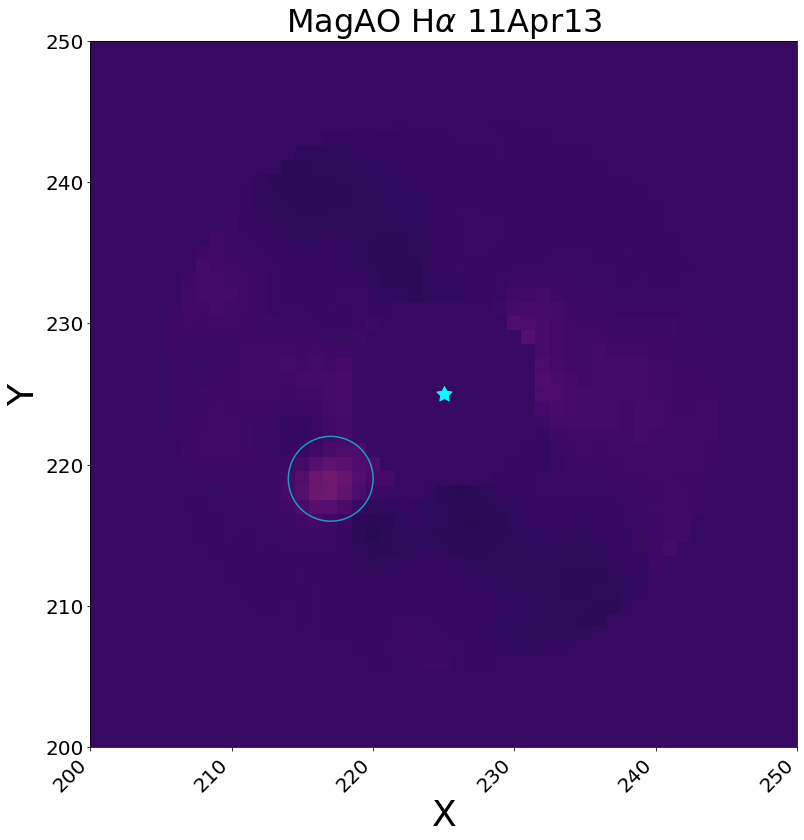

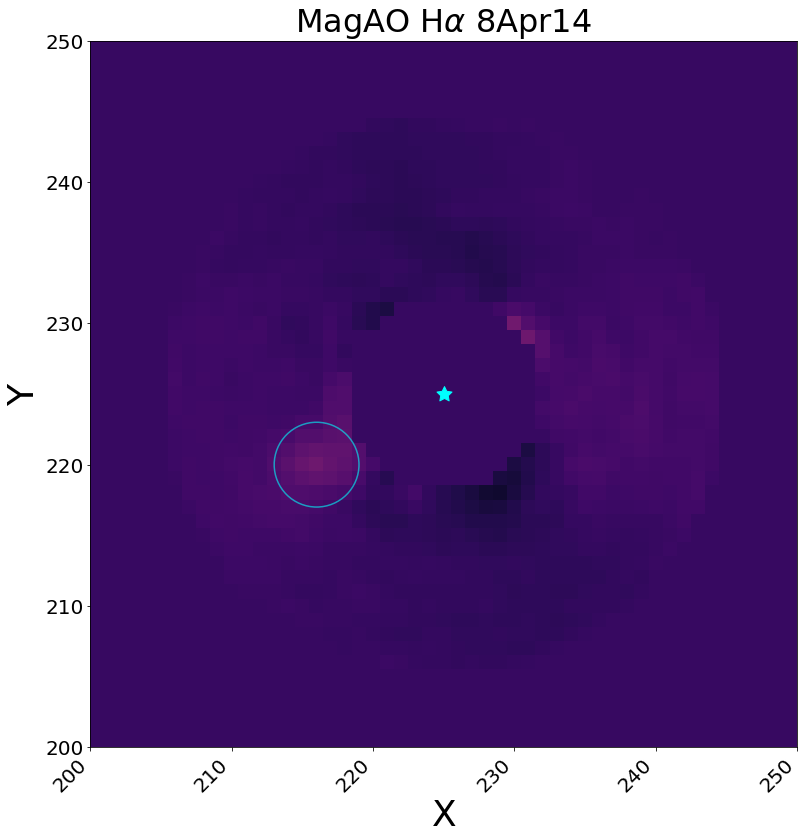

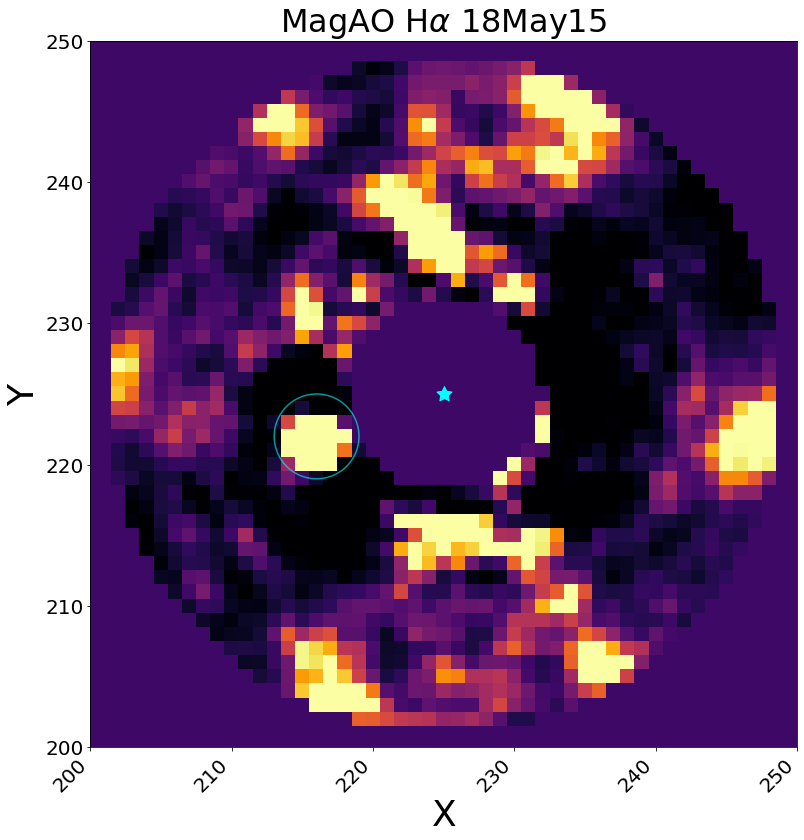

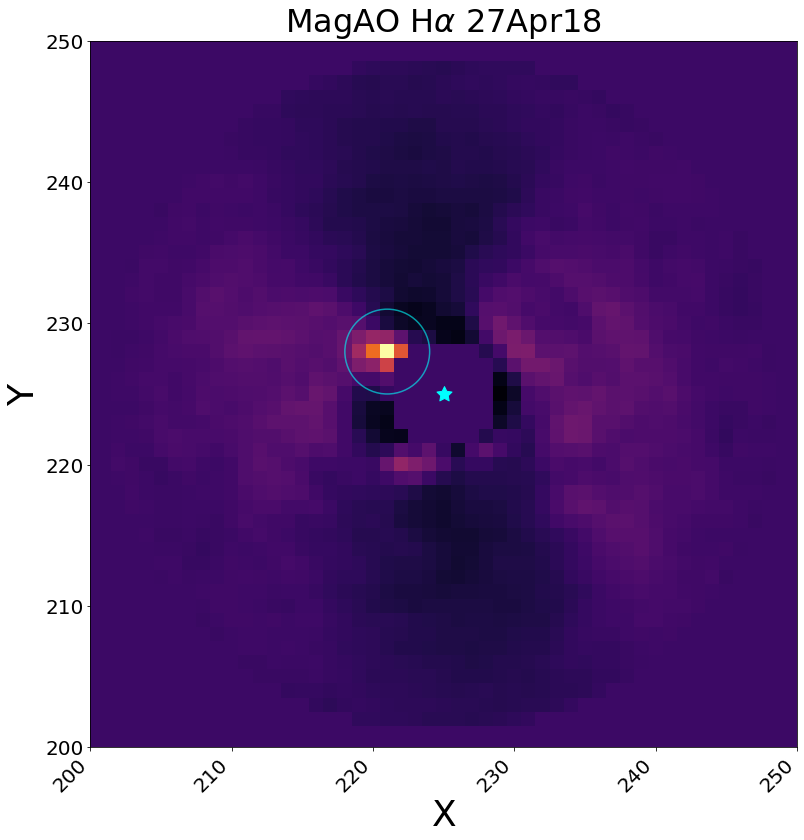

In [78]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

def plot_for_offset(i, saveindiv=False):
    fig, ax = plt.subplots(figsize=(13,13))
    fig.patch.set_alpha(0)
    ax.imshow(domask(imcube[i], inn=inner[i]), origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')
    ax.scatter([225], [225], c='cyan', s=250, marker=(5, 1))
    apertures = CircularAperture(maxes[i], r=3)
    apertures.plot(color='cyan', lw=1.5, alpha=0.6)
    ax.plot()
    ax.set(xlabel='X', ylabel='Y')
    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(ha="right", fontsize=20)
    plt.title(r'MagAO H$\alpha$ {}'.format(date[i]))

    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant
    ax.set_xlim(200, 250)
    ax.set_ylim(200, 250)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if saveindiv is True:
        plt.savefig(date[i]+'_orbit.png', dpi=200)

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit.gif', [plot_for_offset(i) for i in range(len(imlist))], fps=1)

<ipython-input-78-cd2759c73c87>:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(domask(imcube[i], inn=inner[i]), origin='lower', norm=norm, vmin=lims[i][0], vmax=lims[i][1], cmap='inferno')


[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

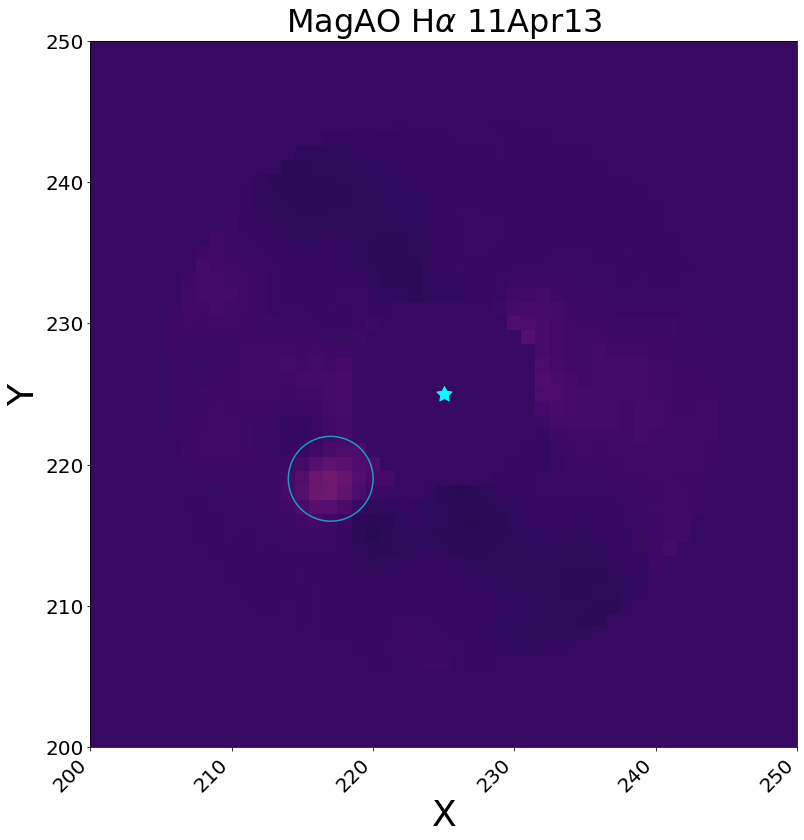

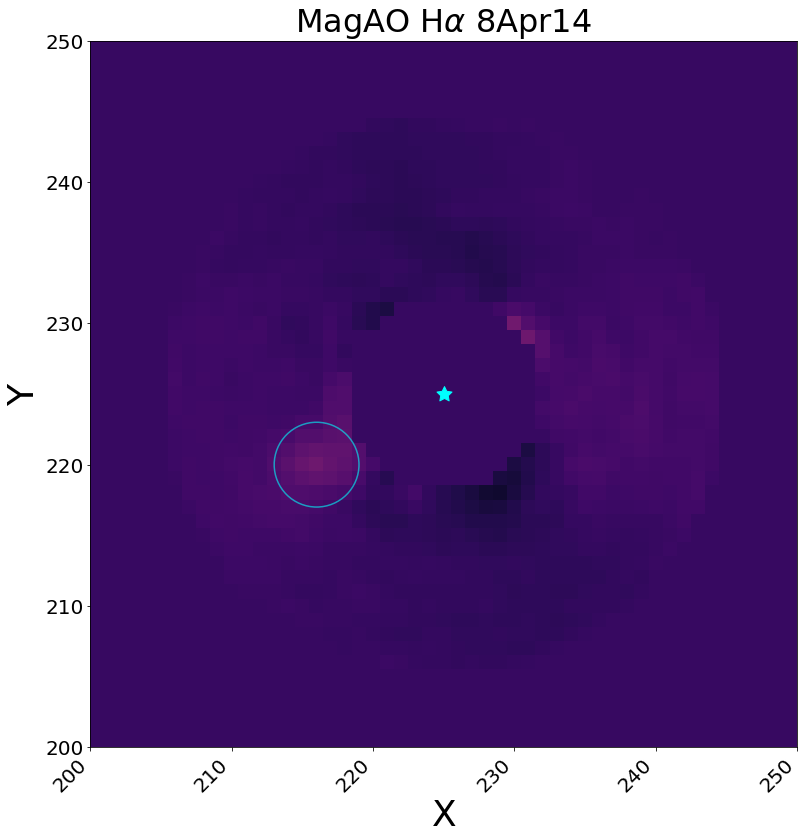

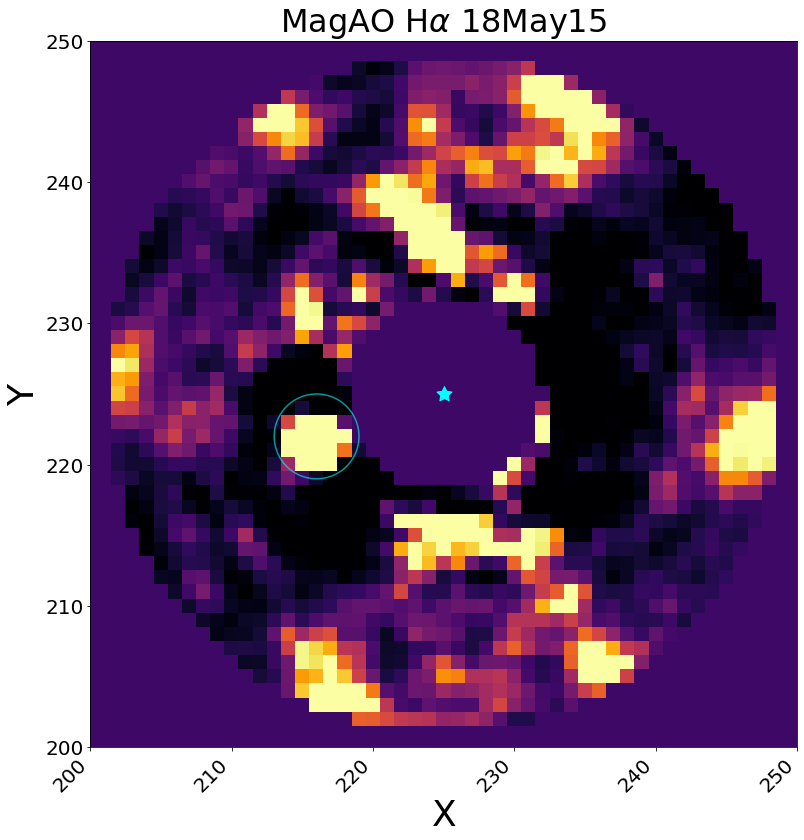

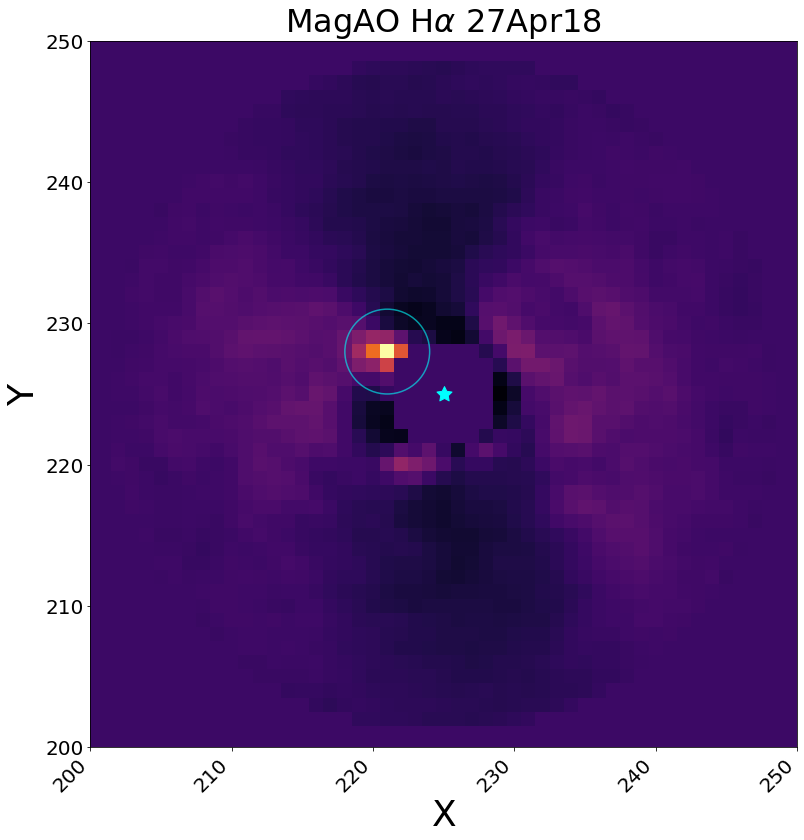

In [79]:
[plot_for_offset(i, saveindiv=True) for i in range(len(imlist))]